## Data Exploration

In [ ]:
# Extension reloader to import a function again when re-running cell 
%load_ext autoreload
%autoreload 2

In [ ]:
from datetime import datetime
program_start_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print('Started: '+ program_start_time)

### Load configuration

In [ ]:
"""
Loads common configuration parameters
"""
import utils.configuration_manager as configuration_manager
from pathlib import PurePath
from os import getcwd

config_path = PurePath(getcwd(),'config.ini')
config = configuration_manager.Config(config_path)

# Assumes parquet directory as input
input_path = config.input_path
print('Input path: '+ input_path)

# For result storage
output_directory = config.output_directory
print('Output path: ' + output_directory)

### Start local Dask Client

In [ ]:
from dask.distributed import Client, LocalCluster
try:
    if client:
        print('Restarting client')
        client.restart()
except:
#     cluster = LocalCluster(dashboard_address=':20100', memory_limit='4G')
    cluster = LocalCluster(dashboard_address=':20100')
    print('Setting new client')
    client = Client(cluster)
    print(client)
client

### Dask dataframe loader

In [5]:
import dask.dataframe as dd
import fastparquet

In [6]:
ddf = dd.read_parquet(input_path)

In [7]:
ddf.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
index,,,,,,,,,,,,,,,,,
0,1,2018-12-03 09:58:01,2018-12-03 10:14:17,1.0,1.20,1,N,186,161,1,11.0,0.0,0.5,2.95,0.00,0.3,14.75
1,2,2018-12-03 09:41:32,2018-12-03 10:20:08,1.0,12.03,1,N,138,162,1,39.0,0.0,0.5,9.11,5.76,0.3,54.67
2,2,2018-12-03 08:54:36,2018-12-03 08:59:35,2.0,0.86,1,N,151,166,1,5.5,0.0,0.5,1.26,0.00,0.3,7.56
3,2,2018-12-03 09:02:08,2018-12-03 09:07:16,2.0,1.09,1,N,166,238,1,6.0,0.0,0.5,1.36,0.00,0.3,8.16
4,2,2018-12-03 09:10:10,2018-12-03 09:21:32,2.0,1.78,1,N,238,75,1,9.5,0.0,0.5,2.06,0.00,0.3,12.36


In [8]:
print(ddf.dtypes)

VendorID                       category
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                     category
store_and_fwd_flag               object
PULocationID                   category
DOLocationID                   category
payment_type                   category
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
dtype: object


## Basic Data Statistics

In [9]:
print(ddf.describe().compute())

       passenger_count  trip_distance   fare_amount         extra  \
count     1.122346e+08   1.122346e+08  1.122346e+08  1.122346e+08   
mean      1.595515e+00   2.929440e+00  1.302615e+01  3.310082e-01   
std       1.241769e+00   1.833739e+01  1.470310e+02  4.659486e-01   
min       0.000000e+00   0.000000e+00 -8.000000e+02 -8.000000e+01   
25%       1.000000e+00   1.060000e+00  7.000000e+00  0.000000e+00   
50%       1.000000e+00   1.800000e+00  1.050000e+01  5.000000e-01   
75%       2.000000e+00   3.580000e+00  1.750000e+01  1.000000e+00   
max       1.920000e+02   1.894838e+05  9.070702e+05  9.664000e+01   

            mta_tax    tip_amount  tolls_amount  improvement_surcharge  \
count  1.122346e+08  1.122346e+08  1.122346e+08           1.122346e+08   
mean   4.971520e-01  1.872474e+00  3.450687e-01           2.996225e-01   
std    5.218331e-02  2.607947e+00  1.781228e+00           6.046083e-01   
min   -5.000000e-01 -3.224200e+02 -5.250000e+01          -3.000000e-01   
25%    5

### Tip by location

In [10]:
pu_location = 'PULocationID'
do_location = 'DOLocationID'
tip = 'tip_amount'

In [11]:
tip_by_region = ddf.groupby(pu_location)[tip].mean()

In [12]:
tip_by_region.compute()

distributed.nanny - WARNING - Restarting worker


PULocationID
1      10.791346
10      6.435483
100     1.481584
101     1.403136
102     1.161811
         ...    
109     6.477368
110     1.185000
99      1.015000
199     3.179474
104     0.000000
Name: tip_amount, Length: 264, dtype: float64

### Tips by day of the week

In [22]:
ddf_test = ddf.groupby([ddf[ts].dt.dayofweek])[tip].mean()

In [23]:
day_of_week = ddf_test.compute()

distributed.nanny - WARNING - Restarting worker


In [55]:
days_dict = {'Monday':0, 
             'Tuesday':1, 
             'Wednesday':2, 
             'Thursday':3, 
             'Friday':4, 
             'Saturday': 5, 
             'Sunday':6}
print(day_of_week)

tpep_pickup_datetime
0    1.899035
1    1.920912
2    1.932224
3    1.988110
4    1.898200
5    1.657446
6    1.801010
Name: tip_amount, dtype: float64


In [68]:
index = {y:x for x, y in days_dict.items()}
day_of_week.index = day_of_week.index.map(index)

In [69]:
print(test)

Index(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'],
      dtype='object', name='tpep_pickup_datetime')


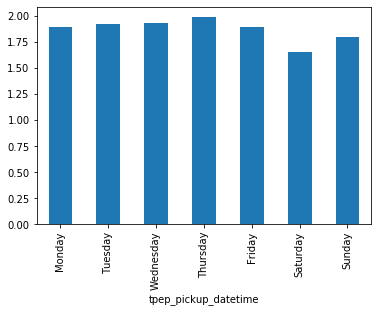

In [70]:
# import matplotlib.pyplot as plt
day_of_week.plot.bar(x='Day of the week', y='Mean tip')

### Seasonal / trends

Let's look at tiping behavior over the course of the year, averaging result by day

In [17]:
time_column =  'tpep_pickup_datetime'
val_column = 'tip_amount'

In [23]:
""" Dynamically set timecourse interval and plot outcome"""
import numpy as np
from pandas import Grouper

In [ ]:
def get_mean_val_by_interval(ddf, time_column, val_column, time_interval = '1min'):
    """
    Get the mean value for a given time interval
    time_column: datetime obj
    val_column: float to average by time_interval
    
    Possible time intervals - https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
    """
    # Have to expand to float64 to prevent overflow and inf outcomes 
    ddf[val_column] = ddf[val_column].astype(np.float64)
#     ddf_by_grouping = ddf.groupby(Grouper(key=time_column, freq=time_interval))
    return ddf.groupby(Grouper(key=time_column, freq=time_interval))[val_column].mean()

get_mean_val_by_interval(ddf_temp, time_column, val_column, time_interval = '1M').compute()